## 0. Imports, Config, and Loading dataset

In [1]:
# config so we can easily change
balance_treatment_type = 'oversampling' # 'undersampling', or 'oversampling'
target_col = 'diabetes'
random_state = 42
dataset_test_size = 0.2
learning_rate = 0.001
epochs = 200
batch_size = 256
loss_function = 'binary_crossentropy' # 'binary_crossentropy', 'categorical_crossentropy', 'sparse_categorical_crossentropy', 'mse', 'mae', 'hinge'
metrics = ['recall'] # 'accuracy', 'precision', 'recall', 'f1_score'
activation_function = 'relu'
output_activation_function = 'sigmoid'
optimizer_type = 'adam'  # 'adam', 'sgd', 'rmsprop'

# Loss function config
gamma = 2.0
alpha = 0.75 # alpha >0.5 is better for recall

# Early stopping configuration
early_stopping_patience = 20 # number of epochs to wait before stopping the training
min_improvement = 0.02 # should improve at least 2% in the validation loss to continue training
early_stopping_monitor = 'recall'

# number of neurons config
n_neurons_input_layer = 10
n_neurons_hidden_layer1 = 64
n_neurons_hidden_layer2 = 32
n_neurons_hidden_layer3 = 16
n_neurons_output_layer = 1

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from utils.early_stopping import CustomEarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [3]:
import mlflow
mlflow.tensorflow.autolog()
mlflow.set_experiment('deep_neural_network')

<Experiment: artifact_location='s3://infnet-mlflow-bucket/2', creation_time=1758497852717, experiment_id='2', last_update_time=1758497852717, lifecycle_stage='active', name='deep_neural_network', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [4]:
file_name = "diabetes_prediction_dataset.csv"

df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "iammustafatz/diabetes-prediction-dataset",
    file_name,
)

If you want to see details about exploratory data analysis, please take a look in the file [exploratory_data_analysis.ipynb](exploratory_data_analysis.ipynb) instead, because this file will be focused in get a deeper model.

## 1. Cleaning the dataset

In [5]:
df.isnull().sum() # we don't have null values in the dataset, so we don't need to handle them

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [6]:
# Convert the column "blood_glucose_level" to float
df['blood_glucose_level'] = df['blood_glucose_level'].astype(float)

In [7]:
# Transform feature gender in binary (Male == 1, Female = 0)
def is_male(gender: str):
    return 1 if gender.strip().lower() == 'male' else 0
df['gender'] = df['gender'].map(is_male)

In [8]:
# Convert the info smoking_history in information if the patient is a smoker or not (binary) 
df['is_smoker'] = df['smoking_history'].map({'never': 0, 'No Info': 0, 'current': 1, 'former': 1, 'ever': 1, 'not current': 0})
# Remove the column "age" from the dataset
df = df.drop(columns=['smoking_history'])

In [9]:
df

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,is_smoker
0,0,80.0,0,1,25.19,6.6,140.0,0,0
1,0,54.0,0,0,27.32,6.6,80.0,0,0
2,1,28.0,0,0,27.32,5.7,158.0,0,0
3,0,36.0,0,0,23.45,5.0,155.0,0,1
4,1,76.0,1,1,20.14,4.8,155.0,0,1
...,...,...,...,...,...,...,...,...,...
99995,0,80.0,0,0,27.32,6.2,90.0,0,0
99996,0,2.0,0,0,17.37,6.5,100.0,0,0
99997,1,66.0,0,0,27.83,5.7,155.0,0,1
99998,0,24.0,0,0,35.42,4.0,100.0,0,0


In [10]:
df.dtypes # all the data is in the correct format to proceed with the model

gender                   int64
age                    float64
hypertension             int64
heart_disease            int64
bmi                    float64
HbA1c_level            float64
blood_glucose_level    float64
diabetes                 int64
is_smoker                int64
dtype: object

## 2. Normalizing the features

In [11]:
# Apply normalization to the continuous features to improve the model performance
continuous_features = ['age', 'blood_glucose_level', 'bmi', 'HbA1c_level']

scaler = StandardScaler()
df[continuous_features] = scaler.fit_transform(df[continuous_features])

In [12]:
df[continuous_features].describe() # normalization was applied correctly

,age,blood_glucose_level,bmi,HbA1c_level
count,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05
mean,1.447553e-16,-2.786749e-16,-1.729816e-16,-3.410605e-18
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-1.856658e+00,-1.426210e+00,-2.608320e+00,-1.893686e+00
25%,-7.943364e-01,-9.349053e-01,-5.561106e-01,-6.794897e-01
50%,4.948073e-02,4.770422e-02,-1.155837e-04,2.545078e-01
75%,8.044750e-01,5.144437e-01,3.404125e-01,6.281067e-01
max,1.692704e+00,3.978142e+00,1.030161e+01,3.243300e+00


## 3. Treating the desbalanceament

In [13]:
def apply_undersampling(df: pd.DataFrame) -> pd.DataFrame:
    # separate the classes
    df_majority = df[df[target_col] == 0]
    df_minority = df[df[target_col] == 1]

    # undersample the majority class
    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=len(df_minority),
        random_state=random_state
    )
    
    # combine the downsampled majority class with the minority class and return the new balanced dataset
    return pd.concat([df_majority_downsampled, df_minority])

def apply_oversampling(df: pd.DataFrame) -> pd.DataFrame:
    # separate the classes
    df_majority = df[df[target_col] == 0]
    df_minority = df[df[target_col] == 1]

    # oversample the minority class
    df_minority_oversampled = resample(
        df_minority,
        replace=True,
        n_samples=len(df_majority),
        random_state=random_state
    )
    
    # combine the oversampled minority class with the majority class and return the new balanced dataset
    return pd.concat([df_majority, df_minority_oversampled])
    
if balance_treatment_type == 'undersampling':
    df = apply_undersampling(df)
elif balance_treatment_type == 'oversampling':
    df = apply_oversampling(df)
else:
    raise ValueError(f"Invalid balance treatment type: {balance_treatment_type}")

In [14]:
print('Number of diabetes 0: ', df[target_col].value_counts()[0])
print('Number of diabetes 1: ', df[target_col].value_counts()[1])

Number of diabetes 0:  91500
Number of diabetes 1:  91500


4. Separate the dataset in train/test

In [15]:
# Separate features and target
X = df.drop(columns=[target_col], axis=1)
y = df[target_col]

# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=dataset_test_size, random_state=random_state)

## 5. Creating Baseline Neural Network

In [16]:
# Define the optimizer
optimizer = 0
if optimizer_type == 'adam':
    optimizer = Adam(learning_rate=learning_rate)
elif optimizer_type == 'sgd':
    optimizer = SGD(learning_rate=learning_rate)
elif optimizer_type == 'rmsprop':
    optimizer = RMSprop(learning_rate=learning_rate)
else:
    raise ValueError(f"Invalid optimizer type: {optimizer_type}")

In [17]:
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_weight = alpha_t * tf.pow((1 - p_t), gamma)
        
        focal_loss = focal_weight * tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return tf.reduce_mean(focal_loss)
    return focal_loss_fixed

In [18]:
# Create the model with the number of neurons in the input layer
model = Sequential([
    Dense(n_neurons_input_layer, activation=activation_function, input_shape=(X_train.shape[1],)),
    Dense(n_neurons_hidden_layer1, activation=activation_function),
    Dense(n_neurons_hidden_layer2, activation=activation_function),
    Dense(n_neurons_hidden_layer3, activation=activation_function),
    Dense(n_neurons_output_layer, activation=output_activation_function)
])

# Compile the model with the optimizer, loss function and metrics
model.compile(
    optimizer=optimizer,
    # custom loss function to improve recall to our specific case
    loss=focal_loss(gamma=gamma, alpha=alpha),
    metrics=metrics
)

/Users/alexandrelara/Documents/storage/c/code/diabetes_neural_network/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
# Early stopping callback
early_stopping = CustomEarlyStopping(
    monitor=early_stopping_monitor,
    min_improvement=min_improvement,
    patience=early_stopping_patience
)

# Train the model
with mlflow.start_run() as run:
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping]
    )

2025/09/22 19:47:30 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.


2025/09/22 19:47:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: No module named 'boto3'


Epoch 1/200
562/572 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 0.0227 - recall: 0.9480Epoch 1: ✅ Improvement detected! recall: 0.9560 (best: 0.9560)


2025/09/22 19:47:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0125 - recall: 0.9560  
Epoch 2/200
475/572 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 0.0067 - recall: 0.9633Epoch 2: ❌ Insufficient improvement. recall: 0.9635 (needs: 0.9760) Wait: 1/20


2025/09/22 19:47:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0064 - recall: 0.9635  
Epoch 3/200
487/572 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 0.0057 - recall: 0.9640Epoch 3: ❌ Insufficient improvement. recall: 0.9641 (needs: 0.9760) Wait: 2/20


2025/09/22 19:47:33 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0056 - recall: 0.9641  
Epoch 4/200
477/572 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 0.0054 - recall: 0.9659Epoch 4: ❌ Insufficient improvement. recall: 0.9648 (needs: 0.9760) Wait: 3/20


2025/09/22 19:47:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0054 - recall: 0.9648  
Epoch 5/200
489/572 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 0.0053 - recall: 0.9649Epoch 5: ❌ Insufficient improvement. recall: 0.9649 (needs: 0.9760) Wait: 4/20


2025/09/22 19:47:35 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0052 - recall: 0.9649  
Epoch 6/200
569/572 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 0.0050 - recall: 0.9660Epoch 6: ❌ Insufficient improvement. recall: 0.9647 (needs: 0.9760) Wait: 5/20


2025/09/22 19:47:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0051 - recall: 0.9647  
Epoch 7/200
478/572 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 0.0052 - recall: 0.9645Epoch 7: ❌ Insufficient improvement. recall: 0.9651 (needs: 0.9760) Wait: 6/20


2025/09/22 19:47:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0050 - recall: 0.9651  
Epoch 8/200
555/572 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 0.0049 - recall: 0.9649Epoch 8: ❌ Insufficient improvement. recall: 0.9651 (needs: 0.9760) Wait: 7/20


2025/09/22 19:47:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0050 - recall: 0.9651  
Epoch 9/200
488/572 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 0.0048 - recall: 0.9665Epoch 9: ❌ Insufficient improvement. recall: 0.9659 (needs: 0.9760) Wait: 8/20


2025/09/22 19:47:38 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0049 - recall: 0.9659  
Epoch 10/200
487/572 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 0.0048 - recall: 0.9669Epoch 10: ❌ Insufficient improvement. recall: 0.9667 (needs: 0.9760) Wait: 9/20


2025/09/22 19:47:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0049 - recall: 0.9667  
Epoch 11/200
571/572 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 0.0049 - recall: 0.9653Epoch 11: ❌ Insufficient improvement. recall: 0.9653 (needs: 0.9760) Wait: 10/20


2025/09/22 19:47:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0048 - recall: 0.9653  
Epoch 12/200
489/572 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 0.0048 - recall: 0.9667Epoch 12: ❌ Insufficient improvement. recall: 0.9665 (needs: 0.9760) Wait: 11/20


2025/09/22 19:47:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0048 - recall: 0.9665  
Epoch 13/200
488/572 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 0.0048 - recall: 0.9639Epoch 13: ❌ Insufficient improvement. recall: 0.9668 (needs: 0.9760) Wait: 12/20


2025/09/22 19:47:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0047 - recall: 0.9668  
Epoch 14/200
494/572 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 0.0046 - recall: 0.9670Epoch 14: ❌ Insufficient improvement. recall: 0.9665 (needs: 0.9760) Wait: 13/20


2025/09/22 19:47:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0047 - recall: 0.9665  
Epoch 15/200
492/572 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 0.0047 - recall: 0.9659Epoch 15: ❌ Insufficient improvement. recall: 0.9668 (needs: 0.9760) Wait: 14/20


2025/09/22 19:47:43 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0047 - recall: 0.9668  
Epoch 16/200
493/572 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 0.0046 - recall: 0.9675Epoch 16: ❌ Insufficient improvement. recall: 0.9672 (needs: 0.9760) Wait: 15/20


2025/09/22 19:47:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0046 - recall: 0.9672  
Epoch 17/200
492/572 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 0.0045 - recall: 0.9682Epoch 17: ❌ Insufficient improvement. recall: 0.9675 (needs: 0.9760) Wait: 16/20


2025/09/22 19:47:45 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0046 - recall: 0.9675  
Epoch 18/200
491/572 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 0.0045 - recall: 0.9682Epoch 18: ❌ Insufficient improvement. recall: 0.9684 (needs: 0.9760) Wait: 17/20


2025/09/22 19:47:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0046 - recall: 0.9684  
Epoch 19/200
528/572 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 0.0045 - recall: 0.9678Epoch 19: ❌ Insufficient improvement. recall: 0.9686 (needs: 0.9760) Wait: 18/20


2025/09/22 19:47:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0045 - recall: 0.9686  
Epoch 20/200
488/572 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 0.0045 - recall: 0.9696Epoch 20: ❌ Insufficient improvement. recall: 0.9693 (needs: 0.9760) Wait: 19/20


2025/09/22 19:47:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0045 - recall: 0.9693  
Epoch 21/200
568/572 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 0.0043 - recall: 0.9693Epoch 21: ❌ Insufficient improvement. recall: 0.9695 (needs: 0.9760) Wait: 20/20

🛑 Early Stopping! Stopped at epoch 21
Best recall: 0.9560


2025/09/22 19:47:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0044 - recall: 0.9695  


2025/09/22 19:47:49 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2025/09/22 19:47:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/22 19:47:50 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/09/22 19:47:54 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/_z/2md

🏃 View run abrasive-midge-869 at: http://54.85.131.89:5000/#/experiments/2/runs/4eb82c22e3d0493dac170e4f71769bf1
🧪 View experiment at: http://54.85.131.89:5000/#/experiments/2


## 6. Analyzing the Baseline neural network metrics

In [20]:
accuracy = history.history['recall'][-1]
print(f"Recall: {(accuracy * 100):.2f}%")

Recall: 96.95%


In [21]:
predictions = model.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)

   1/1144 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step

1144/1144 ━━━━━━━━━━━━━━━━━━━━ 0s 173us/step


In [22]:
cm = confusion_matrix(y_test, predicted_classes)

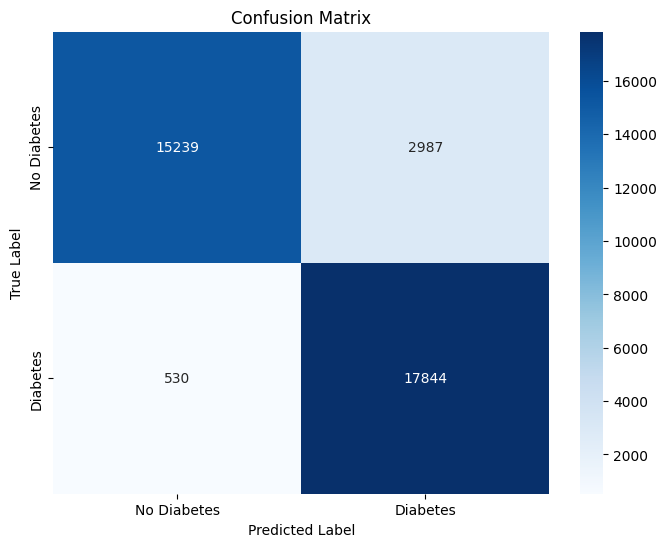

In [23]:
# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [24]:
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

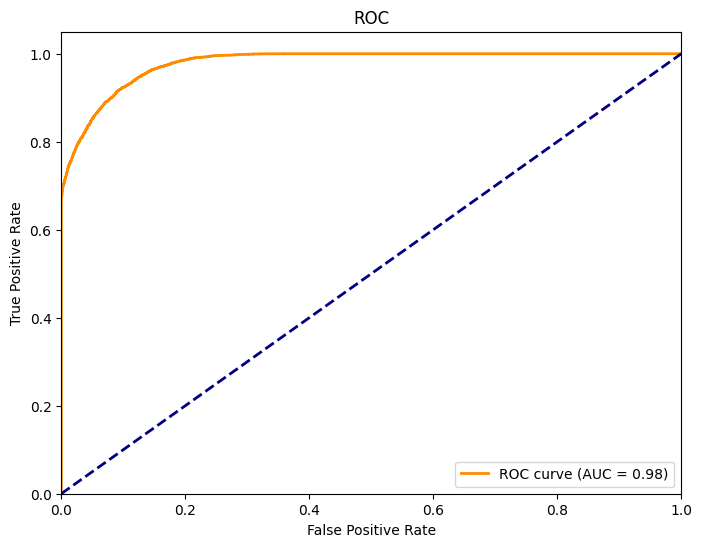

In [25]:
# plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()